<a href="https://colab.research.google.com/github/beercafeguy/PyMLLab/blob/master/practice/Hyperopt_for_RandomForestRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import seaborn as sns

import urllib
import tarfile

from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [9]:
def get_data(url, file_name):
  urllib.request.urlretrieve(url, file_name)
  housing_tgz = tarfile.open(file_name)
  housing_tgz.extractall(path='.')
  housing_tgz.close()

# Download data

In [10]:
download_url = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz'
get_data(download_url, 'housing.tgz')

In [11]:
!ls -ltr

total 1796
-rw-r--r-- 1  501 staff 1423529 May  3  2016 housing.csv
drwxr-xr-x 1 root root     4096 Dec  9 14:20 sample_data
-rw-r--r-- 1 root root   409488 Dec 11 02:03 housing.tgz


# Preview Data

In [12]:
housing_df = pd.read_csv('housing.csv')
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [13]:
housing_df.shape

(20640, 10)

In [14]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [15]:
housing_df.isna().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


<Axes: xlabel='ocean_proximity'>

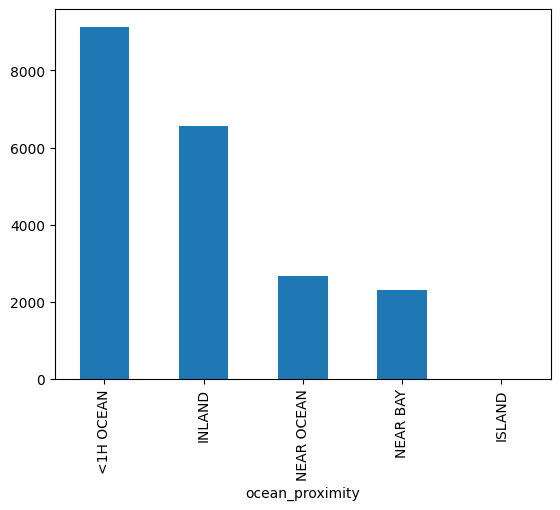

In [17]:
housing_df.ocean_proximity.value_counts().plot(kind='bar')

In [18]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


<Axes: >

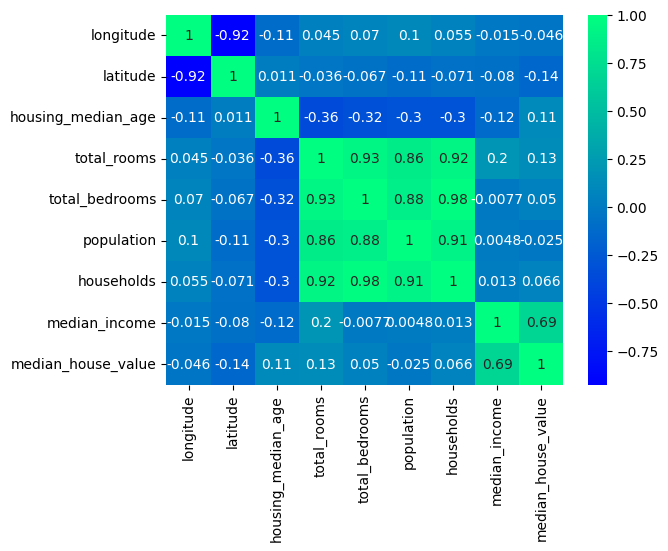

In [23]:
corr = housing_df.corr(numeric_only=True)

sns.heatmap(corr, annot=True, cmap='winter')

# Create New Features

In [32]:
housing_df['rooms_per_household'] = housing_df['total_rooms'] / housing_df['households']
housing_df['bedrooms_per_room'] = housing_df['total_bedrooms'] / housing_df['total_rooms']
housing_df['population_per_household'] = housing_df['population'] / housing_df['households']

# Train Test Split using Stratified Sampling

<Axes: xlabel='income_bucket'>

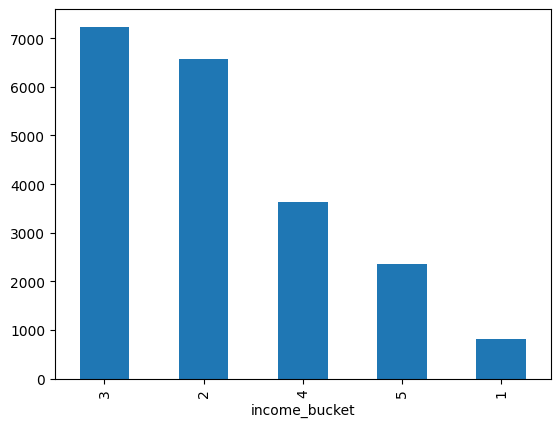

In [33]:
housing_df['income_bucket'] = pd.cut(
    housing_df['median_income'],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5]
)

housing_df['income_bucket'].value_counts().plot(kind='bar')

In [34]:
split = StratifiedShuffleSplit(n_splits = 1, test_size=0.20, random_state=2024)

for train_index, test_index in split.split(housing_df, housing_df['income_bucket']):
  train_data = housing_df.loc[train_index]
  test_data = housing_df.loc[test_index]

<Axes: xlabel='income_bucket'>

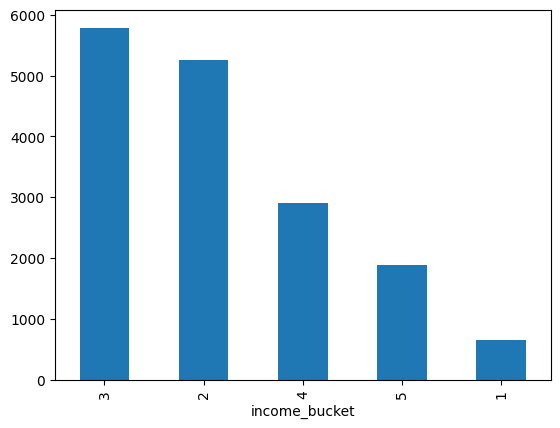

In [35]:
train_data['income_bucket'].value_counts().plot(kind='bar')

<Axes: xlabel='income_bucket'>

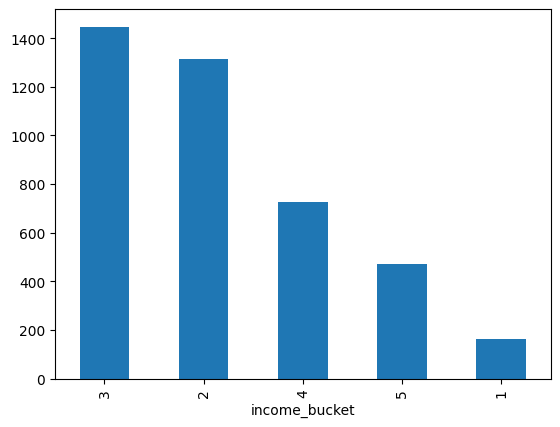

In [36]:
test_data['income_bucket'].value_counts().plot(kind='bar')

In [37]:
train_data.drop('income_bucket', inplace=True, axis='columns')
test_data.drop('income_bucket', inplace=True, axis='columns')

In [42]:
train_data_features = train_data.drop('median_house_value', axis=1)
train_data_target = train_data['median_house_value']

In [75]:
test_data_features = test_data.drop('median_house_value', axis=1)
test_data_target = test_data['median_house_value']

In [44]:
numeric_features = train_data_features.select_dtypes(exclude=['object']).columns.tolist()
categirical_features = train_data_features.select_dtypes(include=['object']).columns.tolist()

print('numeric_features', numeric_features)
print('categirical_features', categirical_features)

numeric_features ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household']
categirical_features ['ocean_proximity']


# Preprocess Data

## Impute Missing Values and Standard Scaling Numeric Features

In [40]:
num_pipeline  = Pipeline(
    [
        ('imputer', SimpleImputer(strategy='median')),
        ('std_scaler', StandardScaler())
    ]
)
num_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('std_scaler', StandardScaler())])

## Categorical Features

In [45]:
preprocessing_pipeline = ColumnTransformer(
    [
        ("num", num_pipeline, numeric_features),
        ("cat", OneHotEncoder(drop='first'), categirical_features)
    ]
)

In [46]:
preprocessing_pipeline.fit(train_data_features)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'rooms_per_household', 'bedrooms_per_room',
                                  'population_per_household']),
                                ('cat', OneHotEncoder(drop='first'),
                                 ['ocean_proximity'])])

In [47]:
train_data_features_transformed = preprocessing_pipeline.transform(train_data_features)

# Building Model

In [66]:
from sklearn.model_selection import train_test_split

In [67]:
X_train, X_test, y_train, y_test = train_test_split(train_data_features_transformed, train_data_target, test_size=0.2, random_state=2024)

In [73]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

from sklearn.metrics import mean_squared_error, root_mean_squared_error
# Define the objective function for hyperopt
def objective(params):
    # Create a RandomForestRegressor with the given hyperparameters
    rf = RandomForestRegressor(
        n_estimators=int(params['n_estimators']),  # RandomForest requires int for n_estimators
        max_depth=int(params['max_depth']),
        min_samples_split=int(params['min_samples_split']),
        min_samples_leaf=int(params['min_samples_leaf']),
        max_features=params['max_features'],  # Corrected to use 'sqrt', 'log2', or an integer
        criterion=params['criterion'],  # Ensure this is a valid string like 'squared_error'
        random_state=42
    )

    # Fit the model
    rf.fit(X_train, y_train)

    # Make predictions and compute Mean Squared Error
    y_pred = rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    # Hyperopt minimizes the objective function, so we return the MSE as the loss
    return {'loss': mse, 'status': STATUS_OK}


# Define the hyperparameter search space
n_estimators = [3, 4, 6, 8]
max_depth = [4, 5, 8, 10, 12, 14]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
max_features = ['sqrt', 'log2', 5, 10]
criterion = ['squared_error', 'poisson', 'friedman_mse', 'absolute_error']
space = {
    'n_estimators': hp.choice('n_estimators', n_estimators),
    'max_depth': hp.choice('max_depth', max_depth),
    'min_samples_split': hp.choice('min_samples_split', min_samples_split),
    'min_samples_leaf': hp.choice('min_samples_leaf', min_samples_leaf),
    'max_features': hp.choice('max_features', max_features),  # Corrected values
    'criterion': hp.choice('criterion', criterion)  # Corrected options
}

# Set up trials object to track optimization progress
trials = Trials()

# Run the optimization using TPE algorithm
best = fmin(
    fn=objective,  # Objective function to minimize
    space=space,  # Search space for hyperparameters
    algo=tpe.suggest,  # TPE optimization algorithm
    max_evals=10,  # Number of iterations
    trials=trials  # Object to track the trials
)

# Output the best hyperparameters found

best_values = {
    'n_estimators': n_estimators[best['n_estimators']],
    'max_depth': max_depth[best['max_depth']],
    'min_samples_split': min_samples_split[best['min_samples_split']],
    'min_samples_leaf': min_samples_leaf[best['min_samples_leaf']],
    'max_features': max_features[best['max_features']],
    'criterion': criterion[best['criterion']],
}
print("Best Hyperparameters:", best_values)

100%|██████████| 10/10 [00:45<00:00,  4.55s/trial, best loss: 2953403506.4624]
Best Hyperparameters: {'n_estimators': 6, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 10, 'criterion': 'squared_error'}


In [74]:
best_model = RandomForestRegressor(
    n_estimators=int(best_values['n_estimators']),
    max_depth=int(best_values['max_depth']),
    min_samples_split=int(best_values['min_samples_split']),
    min_samples_leaf=int(best_values['min_samples_leaf']),
    max_features=best_values['max_features'],
    criterion=best_values['criterion'],
    random_state=42
)

best_model.fit(X_train,y_train)

RandomForestRegressor(max_depth=14, max_features=10, min_samples_split=10,
                      n_estimators=6, random_state=42)

In [76]:
test_data_features_transformed = preprocessing_pipeline.transform(test_data_features)

In [77]:
y_pred_test = best_model.predict(test_data_features_transformed)

In [80]:
root_mean_squared_error(train_data_target, best_model.predict(train_data_features_transformed))

39186.77298801896

In [79]:
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(test_data_target, y_pred_test)

52369.7995467044

This model is overfitting (high varience) as is a the case with most Tree models